In [181]:
# from skimage.io import imread, imsave
from skimage.measure import find_contours, approximate_polygon, label
from skimage import measure
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from biom3d.utils import resize_3d, adaptive_imread

import tifffile as tiff
from skimage import measure
from skimage.transform import resize
from skimage import io
from scipy.spatial import Delaunay
import numpy as np

In [182]:
def tif_read_meta(tif_path, display=False):
    """
    read the metadata of a tif file and stores them in a python dict.
    if there is a 'ImageDescription' tag, it transforms it as a dictionary
    """
    meta = {}
    with tiff.TiffFile(tif_path) as tif:
        for page in tif.pages:
            for tag in page.tags:
                tag_name, tag_value = tag.name, tag.value
                if display: print(tag.name, tag.code, tag.dtype, tag.count, tag.value)

                # below; fix storage problem for ImageDescription tag
                if tag_name == 'ImageDescription': 
                    list_desc = tag_value.split('\n')
                    dict_desc = {}
                    for idx, elm in enumerate(list_desc):
                        split = elm.split('=')
                        dict_desc[split[0]] = split[1]
                    meta[tag_name] = dict_desc
                else:
                    meta[tag_name] = tag_value
            break # just check the first image
    return meta

def tif_get_spacing(path, res=1e-6):
    """
    get the image spacing stored in the metadata file.
    """
    img_meta = tif_read_meta(path)

    xres = (img_meta["XResolution"][1]/img_meta["XResolution"][0])*res
    yres = (img_meta["YResolution"][1]/img_meta["YResolution"][0])*res
    zres = float(img_meta["ImageDescription"]["spacing"])*res

    return (xres, yres, zres)

def tif_read_imagej(img_path):
    """Read tif file metadata stored in a ImageJ format.
    adapted from: https://forum.image.sc/t/python-copy-all-metadata-from-one-multipage-tif-to-another/26597/8

    Parameters
    ----------
    img_path : str
        Path to the input image.

    Returns
    -------
    img : numpy.ndarray
        Image.
    img_meta : dict
        Image metadata. 
    """

    with tiff.TiffFile(img_path) as tif:
        assert tif.is_imagej

        # store img_meta
        img_meta = {}

        # get image resolution from TIFF tags
        tags = tif.pages[0].tags
        x_resolution = tags['XResolution'].value
        y_resolution = tags['YResolution'].value
        resolution_unit = tags['ResolutionUnit'].value
        
        img_meta["resolution"] = (x_resolution, y_resolution, resolution_unit)

        # parse ImageJ metadata from the ImageDescription tag
        ij_description = tags['ImageDescription'].value
        ij_description_metadata = tiff.tifffile.imagej_description_metadata(ij_description)
        # remove conflicting entries from the ImageJ metadata
        ij_description_metadata = {k: v for k, v in ij_description_metadata.items()
                                   if k not in 'ImageJ images channels slices frames'}

        img_meta["description"] = ij_description_metadata
        
        # compute spacing
        xres = (x_resolution[1]/x_resolution[0])
        yres = (y_resolution[1]/y_resolution[0])
        zres = float(ij_description_metadata["spacing"])
        
        img_meta["spacing"] = (xres, yres, zres)

        # read the whole image stack and get the axes order
        series = tif.series[0]
        img = series.asarray()
        
        img_meta["axes"] = series.axes
    
    return img, img_meta

def imread(img_path):
    """
    use skimage imread or sitk imread depending on the file extension:
    .tif --> skimage.io.imread
    .nii.gz --> SimpleITK.imread
    """
    extension = img_path[img_path.rfind('.'):].lower()
    if extension == ".tif" or extension == ".tiff":
        try: 
            img, img_meta = tif_read_imagej(img_path)  # try loading ImageJ metadata for tif files
            return img, img_meta
        except:   
            img_meta = {}    
            try: img_meta["spacing"] = tif_get_spacing(img_path)
            except: img_meta["spacing"] = []
    
            return io.imread(img_path), img_meta 
    else:
        print("[Error] Unknown image format:", extension)

## 2D

In [160]:
path = "D:\\tmp\\test_curve.png"

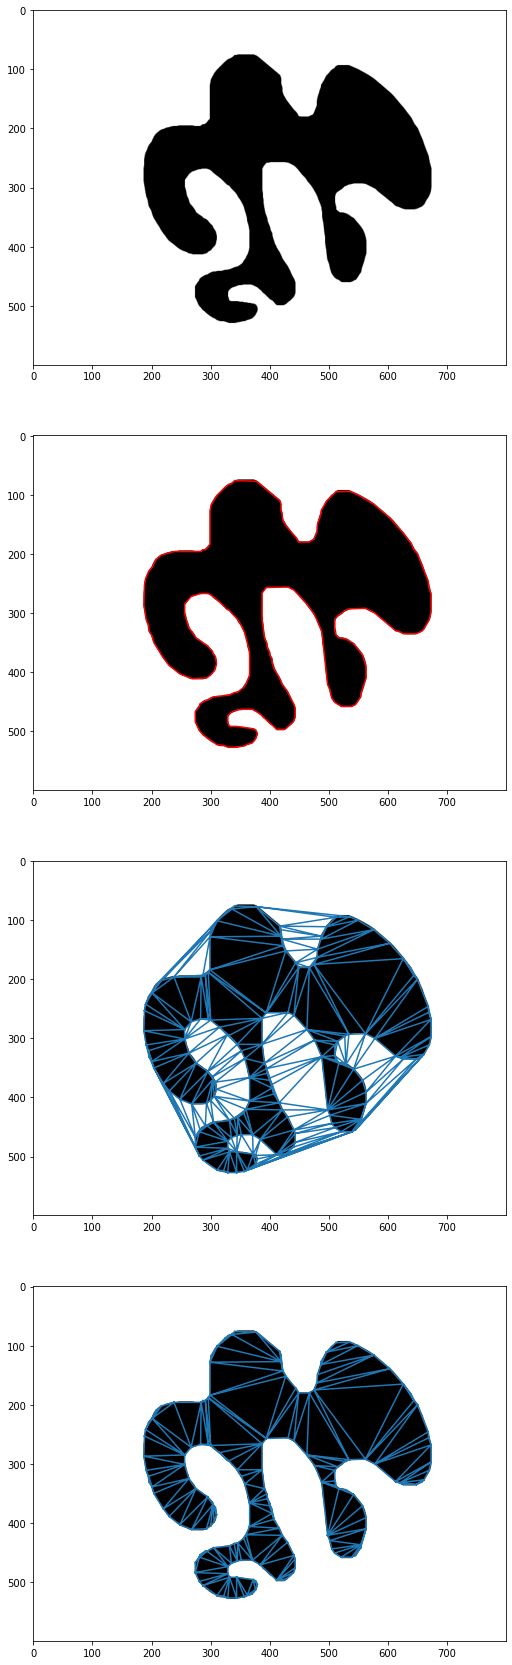

In [161]:
img = imread(path)[...,0]
ls = find_contours(img, 0)
ls = [approximate_polygon(i, 1) for i in ls]
vert = np.vstack(ls)
tri = Delaunay(vert).simplices

plt.figure(figsize=(10,30))
ax = plt.subplot(411)
ax.imshow(img, cmap='gray')

ax = plt.subplot(412)
ax.imshow(img, cmap='gray')
for i in ls: ax.plot(*i.T[::-1], 'red')

ax = plt.subplot(413)
ax.imshow(img, cmap='gray')
plt.triplot(*vert.T[::-1], tri)

ax = plt.subplot(414)
center = vert[tri[:,0]] + vert[tri[:,1]] + vert[tri[:,2]]

msk = img[tuple((center/3).astype(int).T)] == 0
ax.imshow(img, cmap='gray')
plt.triplot(*vert.T[::-1], tri[msk])
plt.show()

## 3D

In [162]:
path = "D:\\tmp\\masks\\220119_cot_hira_dry_C4_119.tif"

(53, 61, 62)


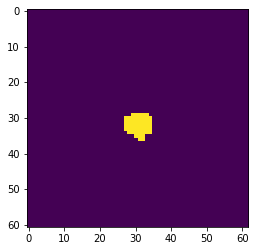

In [163]:
img, metadata = adaptive_imread(path)
print(img.shape)
plt.imshow(img[img.shape[0]//2])

In [164]:
# resample image sampling to (1,1,1)
def get_resample_shape(input_shape, spacing, median_spacing):
    input_shape = np.array(input_shape)
    spacing = np.array(spacing)
    median_spacing = np.array(median_spacing)
    if len(input_shape)==4:
        input_shape=input_shape[1:]
    return np.round(((spacing/median_spacing)[::-1]*input_shape)).astype(int)

spacing = np.array([0.10320000511872025, 0.10320000511872025, 0.19998305084745774])
output_shape = get_resample_shape(img.shape, spacing/spacing.min(), [1,1,1.])
print(img.shape, output_shape)

img = resize_3d(np.array([img]), output_shape, order=1, is_msk=True)[0]

(53, 61, 62) [103  61  62]


In [165]:
# volume with voxel
labels = measure.label(img, background=0)
unq_labels,vol = np.unique(labels, return_counts=True)

In [166]:
# Marching cube
verts, faces, normals, values = measure.marching_cubes(img, 0.5)

In [167]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Fancy indexing: `verts[faces]` to generate a collection of triangles
# mesh = Poly3DCollection(verts[faces])
# mesh.set_edgecolor('k')
# ax.add_collection3d(mesh)

# x,y,z = img.shape
# ax.set_xlim(0, x)  # a = 6 (times two for 2nd ellipsoid)
# ax.set_ylim(0, y)  # b = 10
# ax.set_zlim(0, z)  # c = 16

# plt.tight_layout()
# plt.show()

In [176]:
def mesh3d(verts, img, remove_label=0):
    """Creates a 3D mesh from a list of vertices. Uses the image as a mask to remove unwanted triangles.
    Returns list of triangles.
    https://forum.image.sc/t/create-3d-volume-mesh/34052/9
    """
    # Delaunay
    tri = Delaunay(verts).simplices

    # filter inner triangles only
    center = verts[tri[:,0]] + verts[tri[:,1]] + verts[tri[:,2]] + verts[tri[:,3]]
    msk = img[tuple((center/4).astype(int).T)] != remove_label
    tri_sorted = tri[msk]
    return tri_sorted

tri_sorted = mesh3d(verts, img, remove_label=unq_labels[0])

In [169]:
def tetramesh_vol(a, b, c, d):
    """Volume of a tetrahedron mesh. a, b, c, d are the tetrahedron vertices with 3d coodinates.
    shape of a, b, c, or d are either (3,) or (N,3) where N is the number of vertices in the mesh.
    https://en.wikipedia.org/wiki/Tetrahedron#General_properties
    """
    denom = ((a-d)*(np.cross((b-d),(c-d))))
    denom = denom.sum(axis = 1 if len(denom.shape) > 1 else 0)
    return abs(denom).sum()/6

volume = tetramesh_vol(verts[tri_sorted[:,0]],verts[tri_sorted[:,1]],verts[tri_sorted[:,2]],verts[tri_sorted[:,3]])

In [170]:
surface = measure.mesh_surface_area(verts, faces)

In [171]:
def sphericity(volume, surface):
    """Return sphericity.
    https://en.wikipedia.org/wiki/Sphericity
    """
    return (pow(np.pi,1/3)*pow(6*volume,2/3))/surface

spher = sphericity(volume, surface)

In [ ]:
def resize_segmentation(segmentation, new_shape, order=3):
    '''
    Copied from batch_generator library. Copyleft Fabian Insensee.
    Resizes a segmentation map. Supports all orders (see skimage documentation). Will transform segmentation map to one
    hot encoding which is resized and transformed back to a segmentation map.
    This prevents interpolation artifacts ([0, 0, 2] -> [0, 1, 2])
    :param segmentation:
    :param new_shape:
    :param order:
    :return:
    '''
    tpe = segmentation.dtype
    unique_labels = np.unique(segmentation)
    assert len(segmentation.shape) == len(new_shape), "new shape must have same dimensionality as segmentation"
    if order == 0:
        return resize(segmentation.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False).astype(tpe)
    else:
        reshaped = np.zeros(new_shape, dtype=segmentation.dtype)

        for i, c in enumerate(unique_labels):
            mask = segmentation == c
            reshaped_multihot = resize(mask.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False)
            reshaped[reshaped_multihot >= 0.5] = c
        return reshaped

def resize_3d(img, output_shape, order=3, is_msk=False, monitor_anisotropy=True, anisotropy_threshold=3):
    """
    Resize a 3D image given an output shape.
    
    Parameters
    ----------
    img : numpy.ndarray
        3D image to resample.
    output_shape : tuple, list or numpy.ndarray
        The output shape. Must have an exact length of 3.
    order : int
        The order of the spline interpolation. For images use 3, for mask/label use 0.

    Returns
    -------
    new_img : numpy.ndarray
        Resized image.
    """
    assert len(img.shape)==4, '[Error] Please provided a 3D image with "CWHD" format'
    assert len(output_shape)==3 or len(output_shape)==4, '[Error] Output shape must be "CWHD" or "WHD"'
    
    # convert shape to array
    input_shape = np.array(img.shape)
    output_shape = np.array(output_shape)
    if len(output_shape)==3:
        output_shape = np.append(input_shape[0],output_shape)
    if np.all(input_shape==output_shape): # return image if no reshaping is needed
        return img 
        
    # resize function definition
    resize_fct = resize_segmentation if is_msk else resize
    resize_kwargs = {} if is_msk else {'mode': 'edge', 'anti_aliasing': False}
        
    # separate axis --> [Guillaume] I am not sure about the interest of that... 
    # we only consider the following case: [147,512,513] where the anisotropic axis is undersampled
    # and not: [147,151,512] where the anisotropic axis is oversampled
    anistropy_axes = np.array(input_shape[1:]) / input_shape[1:].min()
    do_anisotropy = monitor_anisotropy and len(anistropy_axes[anistropy_axes>anisotropy_threshold])==2
    if not do_anisotropy:
        anistropy_axes = np.array(output_shape[1:]) / output_shape[1:].min()
        do_anisotropy = monitor_anisotropy and len(anistropy_axes[anistropy_axes>anisotropy_threshold])==2
        
    do_additional_resize = False
    if do_anisotropy: 
        axis = np.argmin(anistropy_axes)
        print("[resize] Anisotropy monitor triggered! Anisotropic axis:", axis)
        
        # as the output_shape and the input_shape might have different dimension
        # along the selected axis, we must use a temporary image.
        tmp_shape = output_shape.copy()
        tmp_shape[axis+1] = input_shape[axis+1]
        
        tmp_img = np.empty(tmp_shape)
        
        length = tmp_shape[axis+1]
        tmp_shape = np.delete(tmp_shape,axis+1)
        
        for c in range(input_shape[0]):
            coord  = [c]+[slice(None)]*len(input_shape[1:])

            for i in range(length):
                coord[axis+1] = i
                tmp_img[tuple(coord)] = resize_fct(img[tuple(coord)], tmp_shape[1:], order=order, **resize_kwargs)
            
        # if output_shape[axis] is different from input_shape[axis]
        # we must resize it again. We do it with order = 0
        if np.any(output_shape!=tmp_img.shape):
            do_additional_resize = True
            order = 0
            img = tmp_img
        else:
            new_img = tmp_img
    
    # normal resizing
    if not do_anisotropy or do_additional_resize:
        new_img = np.empty(output_shape)
        for c in range(input_shape[0]):
            new_img[c] = resize_fct(img[c], output_shape[1:], order=order, **resize_kwargs)
            
    return new_img

In [187]:
def compute_volume_surface_sphericity(img_path, spacing=(), verbose=False):
    """Read a binary image and return the volume, the surface and the spericity of the objects in the image.
    """
    # read image
    img, metadata = imread(path)
    if len(metadata['spacing'])!=0: spacing = metadata['spacing']
        
    assert len(img.shape)==3 or (len(img.shape)==4 and img.shape[0]==1), "[Error] Strange image shape ({}). Please provide a 3d image".format(img.shape)
    
    # warning if no spacing
    if len(spacing)==0:
        print("[Warning] No spacing has been defined. The result will be expressed in voxel units.")
    else:
        # eventually resample image
        output_shape = get_resample_shape(img.shape, spacing/spacing.min(), [1.,1.,1.])
        if len(img.shape)==3:
            img = np.expand_dims(img, 0)
        img = resize_3d(img, output_shape, order=1, is_msk=True)[0]
    
    # compute volume with voxel
    labels = measure.label(img, background=0)
    unq,vol_voxel = np.unique(labels, return_counts=True)
    
    assert len(unq)==2, "[Error] Only 2 class annotations are allowed (0 or 1) but found {}".format(unq)
    
    if verbose: print("Voxel volume:", vol_voxel[1:])
    
    # set background voxels to 0 and foreground to 1
    img = (img != unq[np.argmax(vol)]).astype(np.uint8)
    
    # Marching cube
    verts, faces, normals, values = measure.marching_cubes(img, 0.5) 
    
    # create and sort correct tetrahedron to obtain a volume mesh
    tetra = mesh3d(verts, img, remove_label=unq[0])
    
    # compute the volume
    volume = tetramesh_vol(verts[tetra[:,0]],verts[tetra[:,1]],verts[tetra[:,2]],verts[tetra[:,3]])
    
    # compute the surface
    surface = measure.mesh_surface_area(verts, faces)
    
    # compute the sphericity
    sphere = sphericity(volume, surface)
    
    # eventually adapt to spacing
    if len(spacing)>0:
        volume = volume*np.prod(spacing)
        surface = surface*np.prod(spacing)
    
    # display
    if verbose:
        print("Volume:", volume)
        print("Surface:", surface)
        print("Sphericity:", sphere)
    
    return volume, surface, sphere

In [189]:
compute_volume_surface_sphericity(path, spacing = np.array([0.10320000511872025, 0.10320000511872025, 0.19998305084745774]))

(17.52960986102133, 5.432061689710909, 0.7729507219591464)